# CAICT 風機結冰預測 - Data Exploration 


** second key factor **
** 2017/08/09 **   

http://www.industrial-bigdata.com/competition/competitionAction!showDetail.action?competition.competitionId=1

<a id='home'></a>
### Outline
[1. Modules](#load)  
[2. Input Data](#input)  
[3. Single Variable Exploration](#single)    
[4. Multi-Variable Exploration](#multi)
[5. dimension reduction](#dimen)

In [239]:
%matplotlib inline
import sys
import os
import datetime
import pandas as pd
import numpy as np
import lzma
import pickle
import shutil
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy.stats as stats
import pylab
from pylab import *
import plastid

from collections import OrderedDict
from PIL import Image

from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
from IPython.display import HTML

from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn import preprocessing

import sklearn
import xgboost as xgb
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "last"

# ‘all’|’last’|’last_expr’|’none’

In [240]:
def StandardScaler(data):
    standard_scaler = preprocessing.StandardScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled

def MinMaxScaler(data):
    standard_scaler = preprocessing.MinMaxScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled


def load_resample_data(mid, policy=1,  ycol='power'):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=mid,POLICY=policy)
    print('load file:',filename)
    data_resample = pd.read_csv(filename)
    data_resample['label']=data_resample['label'].fillna(2)

    data_X = data_resample.drop(['label','time','group','timestamp','event'], axis=1)
    data_y = data_resample[ycol]
    data_Y = np.eye(data_y.unique().size)[data_y.values.astype(int)]
    return data_resample, data_X, data_Y, data_y


def load_expo_data(mid=15,policy=0):
    non_data_cols = ['label','time','group','timestamp','event']
    data_raw, data_X, _, _ = load_resample_data(mid=mid,policy=policy)
    data_scaled = MinMaxScaler(data_X)
    for col in non_data_cols:
        data_scaled[col] = data_raw[col]
    return data_raw,data_scaled


In [241]:
def checkPath(path):
    if not os.path.exists(os.path.dirname(path)):
        try:
            os.makedirs(os.path.dirname(path))
        except OSError as exc: 
            if exc.errno != errno.EEXIST:
                raise

In [250]:
def getPostProp(data, col_name):
    prop_Y = len(data[(data['label']==1)])/len(data)
    
    prop_X_dict={}
    target_cut = pd.cut(data[col_name], np.arange(0.0, 1.1, 0.1), labels=range(10))
    data[col_name+'_categ']=target_cut
    target_cnt = target_cut.value_counts()
    for idx, q in target_cnt.items():
        prop_X_dict[idx]= q/len(data)
    #print('prop_X_dict',prop_X_dict)
    prop_XgivenY_dict={}
    data_f = data[data['label']==1]
    target_cnt = data_f[col_name+'_categ'].value_counts()
    for idx, q in target_cnt.items():
        prop_XgivenY_dict[idx]= q/len(data_f)
    print('prop_XgivenY_dict',prop_XgivenY_dict)
    data[col_name+'_postprop1'] = data[col_name+'_categ'].apply(lambda x: prop_Y*prop_XgivenY_dict.get(x)/prop_X_dict.get(x))

def getPostProp2(data, col_name):
    prop_Y1 = len(data[(data['label']==1)])/len(data)
    prop_Y0 = len(data[(data['label']==0)])/len(data)
    
    prop_X_dict={}
    target_cut = pd.cut(data[col_name], np.arange(0.0, 1.1, 0.1), labels=range(10))
    data[col_name+'_categ']=target_cut
    target_cnt = target_cut.value_counts()
    for idx, q in target_cnt.items():
        prop_X_dict[idx]= q/len(data)
    #print('prop_X_dict',prop_X_dict)
    
    prop_XgivenY1_dict={}
    data_f = data[data['label']==1]
    target_cnt = data_f[col_name+'_categ'].value_counts()
    for idx, q in target_cnt.items():
        prop_XgivenY1_dict[idx]= q/len(data_f)
    print('prop_XgivenY1_dict',prop_XgivenY1_dict)
    
    prop_XgivenY0_dict={}
    data_p = data[data['label']==0]
    target_cnt = data_p[col_name+'_categ'].value_counts()
    for idx, q in target_cnt.items():
        prop_XgivenY0_dict[idx]= q/len(data_p)
    print('prop_XgivenY0_dict',prop_XgivenY0_dict)
    
    data[col_name+'_postprop2'] = data[col_name+'_categ'].apply(lambda x: prop_Y1*prop_XgivenY1_dict.get(x)/(prop_Y0*prop_XgivenY0_dict.get(x) + prop_Y1*prop_XgivenY1_dict.get(x)))
    
def getPostProp3(data, col_name):
    prop_Y1 = 0.5
    prop_Y0 = 0.5
    
    prop_X_dict={}
    target_cut = pd.cut(data[col_name], np.arange(0.0, 1.1, 0.1), labels=range(10))
    data[col_name+'_categ']=target_cut
    target_cnt = target_cut.value_counts()
    for idx, q in target_cnt.items():
        prop_X_dict[idx]= q/len(data)
    #print('prop_X_dict',prop_X_dict)
    
    prop_XgivenY1_dict={}
    data_f = data[data['label']==1]
    target_cnt = data_f[col_name+'_categ'].value_counts()
    for idx, q in target_cnt.items():
        prop_XgivenY1_dict[idx]= q/len(data_f)
    print('prop_XgivenY1_dict',prop_XgivenY1_dict)
    
    prop_XgivenY0_dict={}
    data_p = data[data['label']==0]
    target_cnt = data_p[col_name+'_categ'].value_counts()
    for idx, q in target_cnt.items():
        prop_XgivenY0_dict[idx]= q/len(data_p)
    print('prop_XgivenY0_dict',prop_XgivenY0_dict)
    
    data[col_name+'_postprop3'] = data[col_name+'_categ'].apply(lambda x: prop_Y1*prop_XgivenY1_dict.get(x)/(prop_Y0*prop_XgivenY0_dict.get(x) + prop_Y1*prop_XgivenY1_dict.get(x)))
    

<a id='input'></a>
** Input Data **  
data resample policy
- 15號風機
- remove 無效數據
- 沒有做resampling

In [243]:
_, dat_scaled_M15 = load_expo_data(mid=15,policy=0)
#_, dat_scaled_M15 = load_expo_data(mid=15,policy=4)

#dat_scaled_M15_Complete, _ = add_feature_windspeed(dat_scaled_M15_Complete)
#dat_scaled_M15, _ = add_feature_windspeed(dat_scaled_M15)


load file: data/resample_data_p0_15.csv


In [244]:
addgenerator_speed = False

xcols=['wind_speed', 'wind_direction', 'generator_speed',
       'wind_direction_mean', 'yaw_position', 'yaw_speed', 'pitch1_angle',
       'pitch2_angle', 'pitch3_angle', 'pitch1_speed', 'pitch2_speed',
       'pitch3_speed', 'pitch1_moto_tmp', 'pitch2_moto_tmp', 'pitch3_moto_tmp',
       'acc_x', 'acc_y', 'environment_tmp', 'int_tmp', 'pitch1_ng5_tmp',
       'pitch2_ng5_tmp', 'pitch3_ng5_tmp', 'pitch1_ng5_DC', 'pitch2_ng5_DC',
       'pitch3_ng5_DC']

if addgenerator_speed:
    imgpath='case_management/img/power/primary_allx2/'
else:
    xcols.remove('generator_speed')
    imgpath='case_management/img/power/primary_allx/'
    
print(imgpath)

case_management/img/power/primary_allx/


** Exploration **
- Training Data: data_scaled_M15
  - M15
  - scaled
  - resample policy: 0 
  - pass data only
- Prediction Data: data_scaled_M15
  - M15
  - scaled
  - resample policy: 0
- model
  - all x
  - xgboost 
  


** 1. Power vs Wind_speed Scatter **

prop_XgivenY1_dict {0: 0.0, 1: 0.042775824543780344, 2: 0.53616273229532896, 3: 4.1855014230704836e-05, 4: 0.0, 5: 0.24631675874769798, 6: 0.14992466097438473, 7: 0.0, 8: 0.0, 9: 0.024778168424577265}
prop_XgivenY0_dict {0: 0.0034374955389644686, 1: 0.067562204679447832, 2: 0.46844156400336895, 3: 0.15040470514339552, 4: 0.023722716306690841, 5: 0.078891093631782552, 6: 0.16964497294828054, 7: 0.016787768911221825, 8: 0.018440850237683971, 9: 0.0026466431599834407}
prop_XgivenY1_dict {0: 0.0, 1: 0.0028042859534572243, 2: 0.089695295496400471, 3: 0.90126402142976725, 4: 0.0056922819353758579, 5: 0.00050226017076845811, 6: 4.1855014230704836e-05, 7: 0.0, 8: 0.0, 9: 0.0}
prop_XgivenY0_dict {0: 9.9927195900129906e-05, 1: 0.0032005253315441607, 2: 0.095424761959144053, 3: 0.89429986723958255, 4: 0.0063639348474682734, 5: 0.00058814292444076455, 6: 5.7101254800074233e-06, 7: 5.7101254800074233e-06, 8: 2.8550627400037116e-06, 9: 2.8550627400037116e-06}


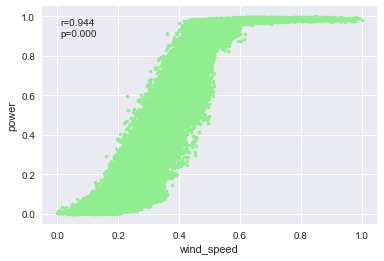

In [253]:
getPostProp3(dat_scaled_M15, 'yaw_position')
getPostProp3(dat_scaled_M15, 'yaw_speed')


data_pass= dat_scaled_M15[dat_scaled_M15['label']==0]
data_fail= dat_scaled_M15[dat_scaled_M15['label']==1]
data_unknown= dat_scaled_M15[dat_scaled_M15['label']==2]

x='wind_speed'
y='power'

r, p = pearsonr(data_pass[x],data_pass[y])
raw_clr = 'lightgreen' if r>0.5 else 'darkgray'

data_visual = data_pass[[y, x]]
plt.plot(data_visual[x],data_visual[y],'.', color=raw_clr)

#data_visual = data_fail[[y, x]]
#plt.plot(data_visual[x],data_visual[y],'.', color='lightcoral')

msg = 'r={corr:.3f}\np={pval:.3f}'.format(corr=r, pval=p)
plt.text(0.01,0.9,msg)
plt.xlabel(x)
plt.ylabel(y)
plt.show(y)

** 2. Predict Power by allX **

In [254]:
data_pass= dat_scaled_M15[dat_scaled_M15['label']==0]
data_fail= dat_scaled_M15[dat_scaled_M15['label']==1]
data_unknown= dat_scaled_M15[dat_scaled_M15['label']==2]

xcols2= xcols.copy()
#xcols2.remove('generator_speed')

x='wind_speed'
y='power'

model = xgb.XGBRegressor()
X = xcols2

model = model.fit(data_pass[X],data_pass[y])
y_pred_p = model.predict(data_pass[X])
y_pred_f = model.predict(data_fail[X])
y_pred_u = model.predict(data_unknown[X])


In [255]:
data_pass['power_pred']=y_pred_p
data_fail['power_pred']=y_pred_f
data_unknown['power_pred']=y_pred_u

data_pass['preddiff'] = pd.ewma(data_pass['power'], halflife=20) - pd.ewma(data_pass['power_pred'], halflife=20)  
data_fail['preddiff'] = pd.ewma(data_fail['power'], halflife=20) - pd.ewma(data_fail['power_pred'], halflife=20)  
data_unknown['preddiff'] = pd.ewma(data_unknown['power'], halflife=20) - pd.ewma(data_unknown['power_pred'], halflife=20)  
 
r2_p = sklearn.metrics.r2_score(data_pass[y],y_pred_p)
r2_f = sklearn.metrics.r2_score(data_fail[y],y_pred_f)
pred_clr = 'firebrick' if r2_p > 0.8 else 'royalblue'

rss_p = (data_pass[y] - y_pred_p)**2
rss_f = (data_fail[y] - y_pred_f)**2

r2_baseline = r2_p

** plot for all data **

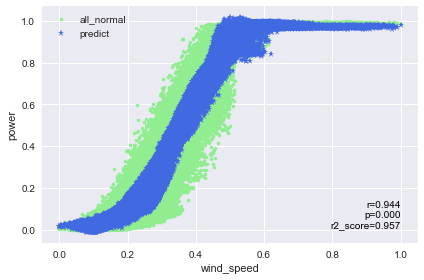

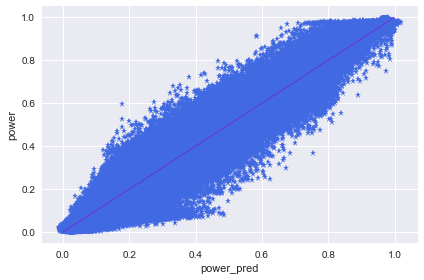

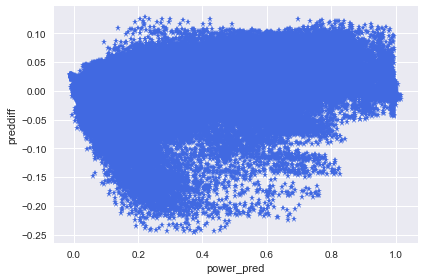

In [256]:
path=imgpath+'scatter/'
checkPath(path)

x='wind_speed'
y='power'
r, p = pearsonr(data_pass[x],data_pass[y])
raw_clr = 'lightgreen' if r>0.5 else 'darkgray'

plt.plot(data_pass[x],data_pass[y],'.', color=raw_clr, label='all_normal')
#plt.plot(data_fail[x],data_fail[y],'.', color='lightcoral')
plt.plot(data_pass[x],data_pass['power_pred'],'*', color='royalblue',label='predict')
#plt.plot(data_fail[x],y_pred_f,'*', color='firebrick')
msg = 'r={corr:.3f}\np={pval:.3f}\nr2_score={r2:.3f}'.format(corr=r, pval=p,r2=r2_baseline)
#plt.text(0.01,0.9,msg)
plt.text(1,0,msg, color='black', horizontalalignment='right', verticalalignment='bottom')
plt.xlabel(x)
plt.ylabel(y)
plt.legend()
plt.tight_layout()
imagename='{p}{n}.jpg'.format(p=path, n='all')
plt.savefig(imagename,bbox_inches='tight', dpi=200)
plt.show()

path=imgpath+'scatter2/'
checkPath(path)

plt.plot(data_pass['power_pred'], data_pass[y],'*', color='royalblue')
plt.plot([0,1],[0,1],color='darkviolet',lw=0.5,  label='this event ewma')
plt.xlabel('power_pred')
plt.ylabel('power')
plt.tight_layout()
imagename='{p}{n}.jpg'.format(p=path, n='all')
plt.savefig(imagename,bbox_inches='tight', dpi=200)
plt.show()

path=imgpath+'scatter3/'
checkPath(path)
plt.plot(data_pass['power_pred'], data_pass['preddiff'],'*', color='royalblue')
plt.xlabel('power_pred')
plt.ylabel('preddiff')
plt.tight_layout()
imagename='{p}{n}.jpg'.format(p=path, n='all')
plt.savefig(imagename,bbox_inches='tight', dpi=200)
plt.show()

** plot for each event **

In [259]:
data_evt[:4]

,wind_speed,generator_speed,power,wind_direction,wind_direction_mean,yaw_position,yaw_speed,pitch1_angle,pitch2_angle,pitch3_angle,pitch1_speed,pitch2_speed,pitch3_speed,pitch1_moto_tmp,pitch2_moto_tmp,pitch3_moto_tmp,acc_x,acc_y,environment_tmp,int_tmp,pitch1_ng5_tmp,pitch2_ng5_tmp,pitch3_ng5_tmp,pitch1_ng5_DC,pitch2_ng5_DC,pitch3_ng5_DC,label,time,group,timestamp,event,yaw_position_categ,yaw_position_postprop3,yaw_speed_categ,yaw_speed_postprop3
0,0.510889,0.918713,0.982676,0.303308,0.427861,0.227932,0.322727,0.047012,0.043593,0.045714,0.314063,0.331250,0.311606,0.749716,0.697987,0.742492,0.363636,0.538462,0.415592,0.628210,0.838473,0.354135,0.288158,0.725714,0.508197,0.742331,0.0,2015-11-01 20:20:16,1,1.446380e+09,0,2,0.533705,3,0.501939
1,0.517241,0.936494,0.928011,0.309088,0.455120,0.227932,0.322727,0.011424,0.006605,0.010110,0.379688,0.398438,0.378378,0.751989,0.700000,0.744857,0.545455,0.461538,0.412439,0.624654,0.838473,0.354135,0.288158,0.594286,0.901639,0.104294,0.0,2015-11-01 20:20:23,1,1.446380e+09,0,2,0.533705,3,0.501939
2,0.483212,0.933108,0.980516,0.305074,0.534337,0.229117,0.340909,0.087434,0.087627,0.086154,0.306250,0.326562,0.313196,0.751989,0.700000,0.746985,0.454545,0.538462,0.412439,0.624654,0.838473,0.354135,0.288158,0.782857,0.590164,0.895706,0.0,2015-11-01 20:20:30,1,1.446380e+09,0,2,0.533705,3,0.501939
3,0.501815,0.933108,0.937753,0.309409,0.418298,0.227932,0.318182,0.008787,0.007045,0.008791,0.379688,0.398438,0.378378,0.754490,0.704698,0.749350,0.454545,0.538462,0.415592,0.624654,0.838473,0.354135,0.288158,0.931429,0.442623,0.521472,0.0,2015-11-01 20:20:37,1,1.446380e+09,0,2,0.533705,3,0.501939


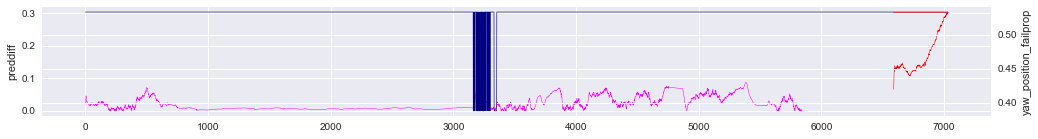

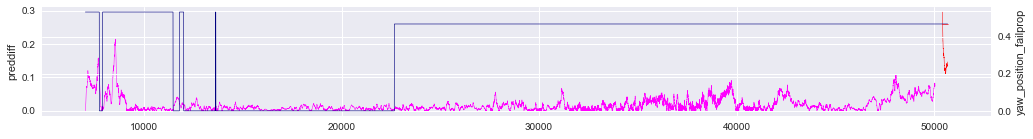

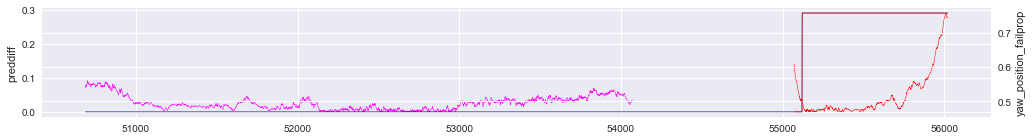

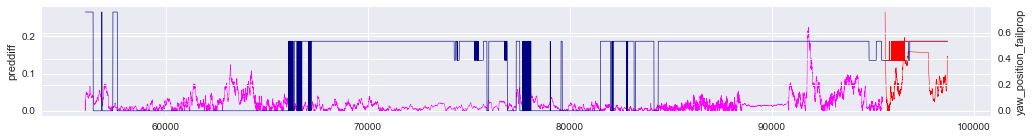

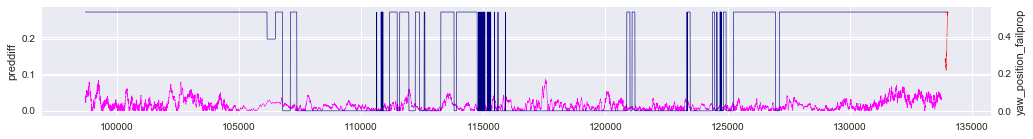

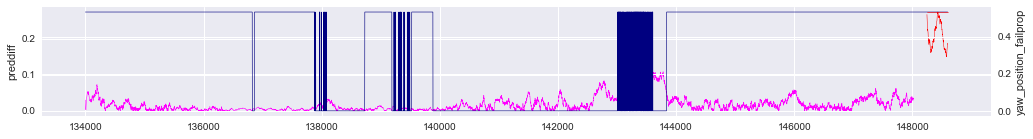

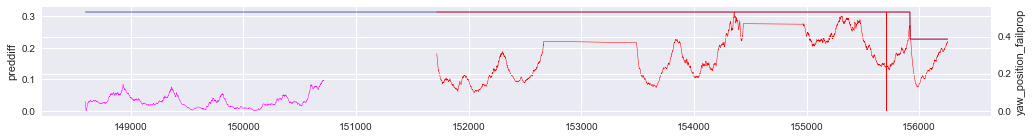

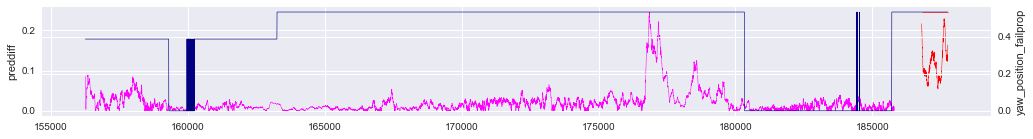

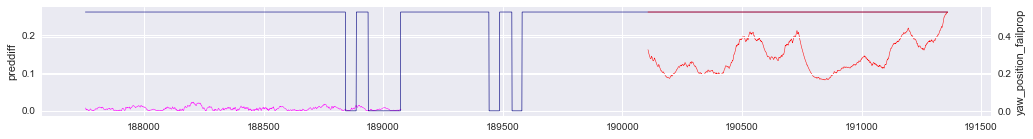

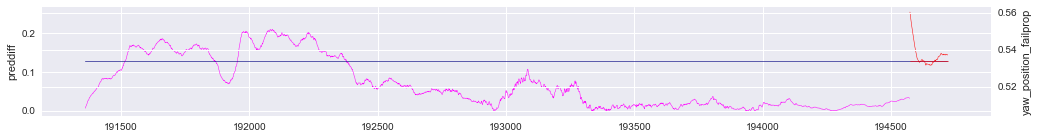

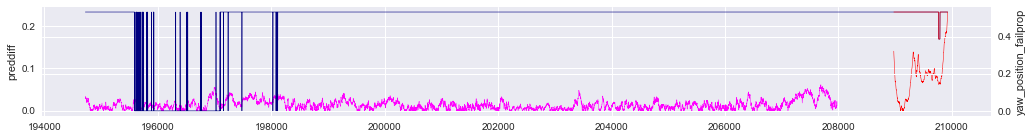

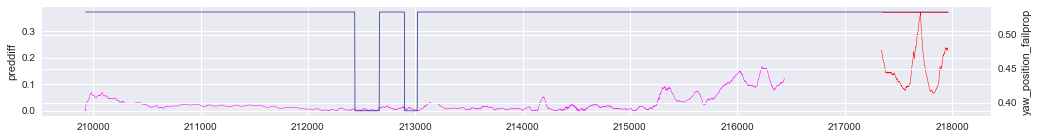

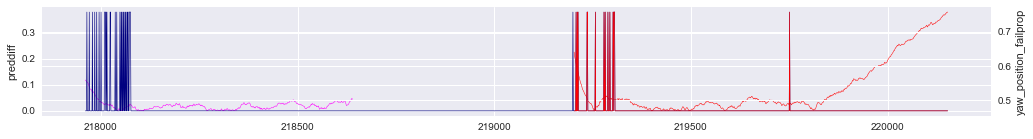

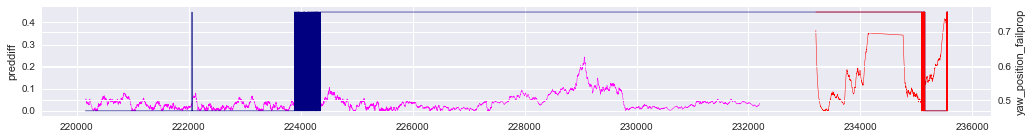

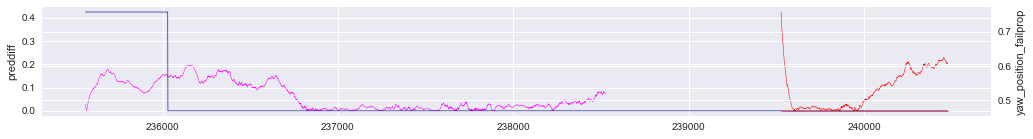

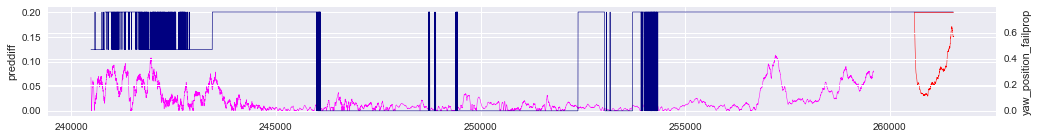

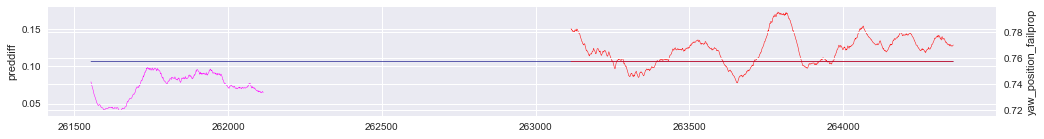

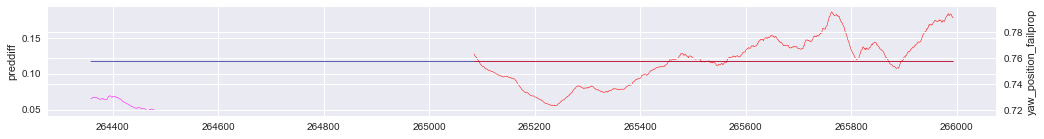

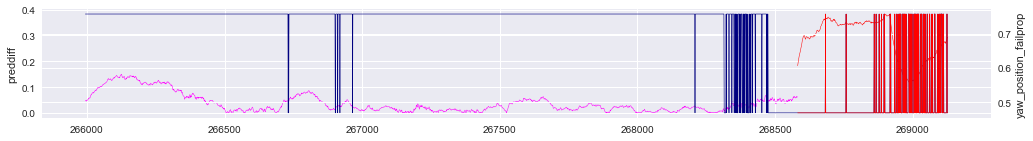

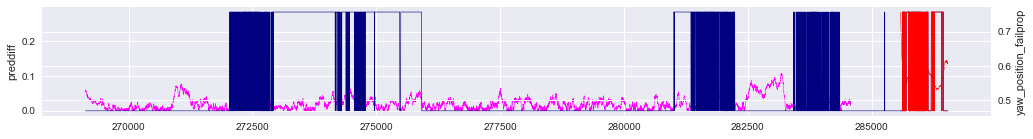

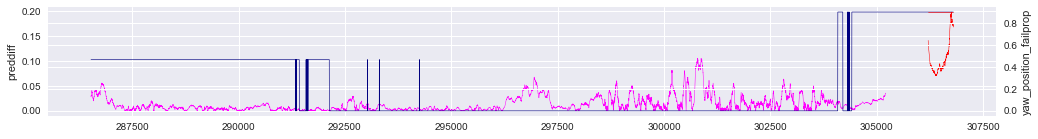

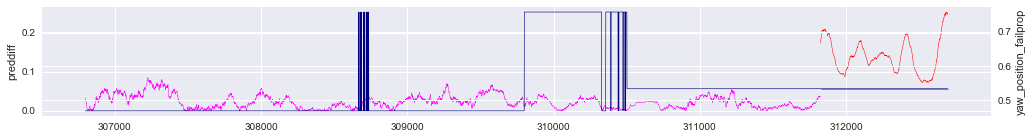

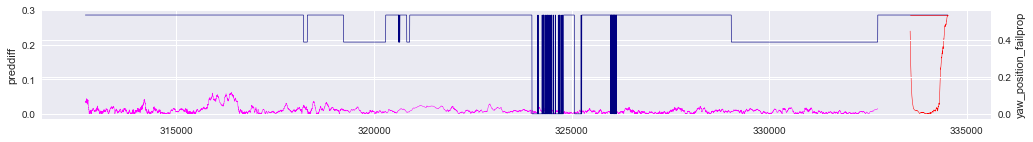

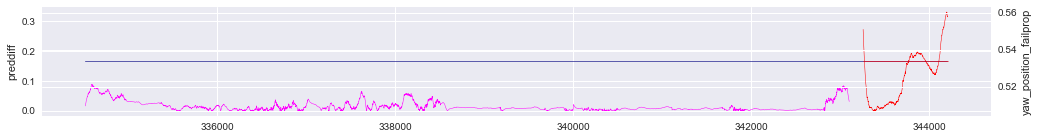

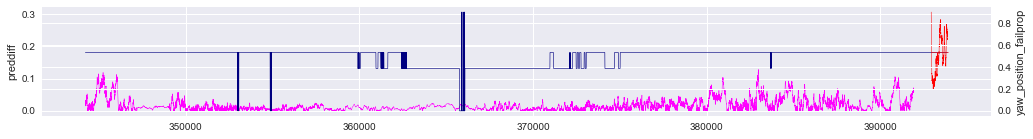

In [260]:
path_scatter1=imgpath+'scatter/'
checkPath(path_scatter1)
path_scatter2=imgpath+'scatter2/'
checkPath(path_scatter2)
path_scatter3=imgpath+'scatter3/'
checkPath(path_scatter3)
path_trend1=imgpath+'trend_d/'
checkPath(path_trend1)
path_trend1_dif=imgpath+'trend_d_dif/'
checkPath(path_trend1_dif)
path_trend2=imgpath+'trend_t/'
checkPath(path_trend2)

path_trend3=imgpath+'trend3/'
checkPath(path_trend3)

events = data_pass['event'].unique()
x='wind_speed'
y='power'

plot_scatter1 = False
plot_scatter2 = False
plot_scatter3 = False
plot_trend1 = False
plot_trend2 = True
plot_trend3 = False

for e in events:
    data_evt = dat_scaled_M15[dat_scaled_M15['event']==e]
    data_pass_evt= data_pass[data_pass['event']==e]
    data_fail_evt= data_fail[data_fail['event']==e]
    data_unknown_evt = data_unknown[data_unknown['event']==e]
    
    
    if plot_scatter1: 
        r, p = pearsonr(data_pass_evt[x],data_pass_evt[y])
        raw_clr = 'lightgreen' if r>0.5 else 'darkgray'
        plt.plot(data_pass[x],data_pass[y],'.', color='darkgray', label='all_normal')
        #plt.plot(data_fail[x],data_fail[y],'.', color='lightcoral')
        #plt.plot(data_pass[x],data_pass['power_pred'],'*', color='royalblue', label='predict')
        #plt.plot(data_fail[x],y_pred_f,'*', color='firebrick')
        plt.plot(data_pass_evt[x],data_pass_evt[y],'.', color='lemonchiffon', label='this event')
        plt.plot(data_pass_evt[x],data_pass_evt['power_pred'],'*', color='royalblue', label='predict')
        r2_p = sklearn.metrics.r2_score(data_pass_evt[y],data_pass_evt['power_pred'])
        msg = 'r={corr:.3f}\np={pval:.3f}\nr2_score={r2:.3f}'.format(corr=r, pval=p,r2=r2_p)
        txt_clr = 'red' if r2_p < r2_baseline else 'black'
        plt.text(1,0,msg, color=txt_clr, horizontalalignment='right', verticalalignment='bottom')
        plt.title('event '+str(e))
        plt.xlabel(x)
        plt.ylabel(y)
        plt.legend()
        plt.tight_layout()
        imagename='{p}{n}.jpg'.format(p=path_scatter1,n=str(e))
        plt.savefig(imagename,bbox_inches='tight', dpi=200)
        plt.show()
    
    if plot_scatter2:
        plt.plot(data_pass['power_pred'], data_pass[y],'*', color='darkgray')
        plt.plot(data_pass_evt['power_pred'], data_pass_evt[y],'*', color='lemonchiffon')
        plt.plot([0,1],[0,1],color='darkviolet',lw=0.5,  label='this event ewma')
        plt.xlabel('power_pred')
        plt.ylabel('power')
        plt.tight_layout()
        imagename='{p}{n}.jpg'.format(p=path_scatter2, n=str(e))
        plt.savefig(imagename,bbox_inches='tight', dpi=200)
        plt.show()

    if plot_scatter3:
        plt.plot(data_pass['power_pred'], data_pass['preddiff'],'*', color='darkgray')
        plt.plot(data_pass_evt['power_pred'], data_pass_evt['preddiff'],'*', color='lemonchiffon')
        plt.plot([0,1],[0,0],color='darkviolet',lw=0.5,  label='this event ewma')
        plt.xlabel('power_pred')
        plt.ylabel('preddiff')
        plt.tight_layout()
        imagename='{p}{n}.jpg'.format(p=path_scatter3, n=str(e))
        plt.savefig(imagename,bbox_inches='tight', dpi=200)
        plt.show()

    
# X: Datapoint
    if plot_trend1:
        # pass
        dummy = plt.figure(figsize=[17,2])
        plt.plot(data_pass_evt[y], color = 'lemonchiffon', lw=0.5, label='this event')
        plt.plot(pd.ewma(data_pass_evt['power_pred'], halflife=20), color='royalblue', lw=0.5, label='predict ewma')
        plt.plot(pd.ewma(data_pass_evt[y], halflife=20), color='sandybrown', lw=0.5, label='this event ewma')
        plt.plot(abs(data_pass_evt['preddiff']), color='magenta', lw=0.5, label='predict diff')
        plt.vlines(data_pass_evt.index[-1],0, 1,'gray')
        # unknown
        if not data_unknown_evt.empty:
            plt.plot(data_unknown_evt[y], color = 'lemonchiffon', lw=0.5)
            plt.plot(pd.ewma(data_unknown_evt['power_pred'], halflife=20), color='royalblue', lw=0.5)
            plt.plot(pd.ewma(data_unknown_evt[y], halflife=20), color='sandybrown', lw=0.5)
            plt.plot(abs(data_unknown_evt['preddiff']), color='magenta', lw=0.5, )
            plt.vlines(data_unknown_evt.index[-1],0, 1,'red')
        #fail
        plt.plot(data_fail_evt[y], color = 'lemonchiffon', lw=0.8)
        plt.plot(pd.ewma(data_fail_evt['power_pred'], halflife=20), color='royalblue', lw=0.8)
        plt.plot(pd.ewma(data_fail_evt[y], halflife=20), color='sandybrown', lw=0.8)
        plt.plot(abs(data_fail_evt['preddiff']), color='magenta', lw=0.5, )   
        plt.ylim((0,1))
        plt.xlabel('data point')
        plt.ylabel(y)
        #plt.legend()
        plt.title('event '+str(e))
        plt.tight_layout()
        imagename='{p}{n}.jpg'.format(p=path_trend1, n=str(e))
        plt.savefig(imagename,bbox_inches='tight', dpi=200)
        plt.show()
    
    if plot_trend2:
        fig = plt.figure(figsize=[17,2])
        ax1 = fig.add_subplot(111)
        ax1.plot(abs(data_pass_evt['preddiff']), color='magenta', lw=0.5, label='predict diff')
        ax1.plot(abs(data_fail_evt['preddiff']), color='red', lw=0.5, )  
        ax1.set_ylabel('preddiff')
        ax2 = ax1.twinx()
        y_ = 'yaw_position'
        ax2.plot(data_evt[y_+'_postprop3'], color='navy', lw=0.6, label=y_+'_postprop3')
        ax2.plot(data_fail_evt[y_+'_postprop3'], color='red', lw=0.6, label=y_+'_postprop3')
        ax2.set_ylabel('yaw_position_failprop')
        
        #plt.plot(abs(data_pass_evt['preddiff']), color='magenta', lw=0.5, label='predict diff')
        #plt.vlines(data_pass_evt.index[-1],0, 0.3,'gray')
        #if not data_unknown_evt.empty:
        #    plt.plot(abs(data_unknown_evt['preddiff']), color='magenta', lw=0.5, )
        #    plt.vlines(data_unknown_evt.index[-1],0, 0.3,'red')
        #plt.plot(abs(data_fail_evt['preddiff']), color='magenta', lw=0.5, )   
        imagename='{p}{n}.jpg'.format(p=path_trend1_dif, n=str(e))
        plt.savefig(imagename,bbox_inches='tight', dpi=200)
        plt.show()
    
    if plot_trend3:
        y_ = 'yaw_position'
        dummy = plt.figure(figsize=[17,2])
        plt.plot(data_evt[y_], color='cyan', lw=0.6, label=y_)
        plt.plot(data_fail_evt[y_], color='red', lw=0.6, label=y_)
        imagename='{p}_{y}_{n}_raw.jpg'.format(p=path_trend3, n=str(e),y=y_)
        plt.savefig(imagename,bbox_inches='tight', dpi=200)
        plt.show()
        dummy = plt.figure(figsize=[17,2])
        plt.plot(data_evt[y_+'_postprop'], color='navy', lw=0.6, label=y_+'_postprop')
        plt.plot(data_fail_evt[y_+'_postprop'], color='red', lw=0.6, label=y_+'_postprop')
        imagename='{p}_{y}_{n}_postprop.jpg'.format(p=path_trend3, n=str(e),y=y_)
        plt.savefig(imagename,bbox_inches='tight', dpi=200)
        plt.show()
        
        y_ = 'yaw_speed'
        dummy = plt.figure(figsize=[17,2])
        plt.plot(data_evt[y_], color='cyan', lw=0.6, label=y_)
        plt.plot(data_fail_evt[y_], color='red', lw=0.6, label=y_)
        imagename='{p}_{y}_{n}_raw.jpg'.format(p=path_trend3, n=str(e),y=y_)
        plt.savefig(imagename,bbox_inches='tight', dpi=200)
        plt.show()
        dummy = plt.figure(figsize=[17,2])
        plt.plot(data_evt[y_+'_postprop'], color='navy', lw=0.6, label=y_+'_postprop')
        plt.plot(data_fail_evt[y_+'_postprop'], color='red', lw=0.6, label=y_+'_postprop')
        imagename='{p}_{y}_{n}_postprop.jpg'.format(p=path_trend3, n=str(e),y=y_)
        plt.savefig(imagename,bbox_inches='tight', dpi=200)
        plt.show()
        
        

In [238]:
data_pass_evt[:3]

,wind_speed,generator_speed,power,wind_direction,wind_direction_mean,yaw_position,yaw_speed,pitch1_angle,pitch2_angle,pitch3_angle,pitch1_speed,pitch2_speed,pitch3_speed,pitch1_moto_tmp,pitch2_moto_tmp,pitch3_moto_tmp,acc_x,acc_y,environment_tmp,int_tmp,pitch1_ng5_tmp,pitch2_ng5_tmp,pitch3_ng5_tmp,pitch1_ng5_DC,pitch2_ng5_DC,pitch3_ng5_DC,label,time,group,timestamp,event,yaw_position_categ,yaw_position_postprop,yaw_speed_categ,yaw_speed_postprop,power_categ,power_postprop,environment_tmp_categ,environment_tmp_postprop,generator_speed_categ,generator_speed_postprop,int_tmp_categ,int_tmp_postprop,pitch1_ng5_tmp_categ,pitch1_ng5_tmp_postprop,yaw_position_postprop2,yaw_position_postprop1,yaw_position_postprop3,yaw_speed_postprop3
0,0.510889,0.918713,0.982676,0.303308,0.427861,0.227932,0.322727,0.047012,0.043593,0.045714,0.314063,0.331250,0.311606,0.749716,0.697987,0.742492,0.363636,0.538462,0.415592,0.628210,0.838473,0.354135,0.288158,0.725714,0.508197,0.742331,0.0,2015-11-01 20:20:16,1,1.446380e+09,0,2,0.07242,3,0.061075,9,0.0,4,0.041023,9,0.012012,6,0.036476,8,0.024729,0.07242,0.07242,0.547321,0.515641
1,0.517241,0.936494,0.928011,0.309088,0.455120,0.227932,0.322727,0.011424,0.006605,0.010110,0.379688,0.398438,0.378378,0.751989,0.700000,0.744857,0.545455,0.461538,0.412439,0.624654,0.838473,0.354135,0.288158,0.594286,0.901639,0.104294,0.0,2015-11-01 20:20:23,1,1.446380e+09,0,2,0.07242,3,0.061075,9,0.0,4,0.041023,9,0.012012,6,0.036476,8,0.024729,0.07242,0.07242,0.547321,0.515641
2,0.483212,0.933108,0.980516,0.305074,0.534337,0.229117,0.340909,0.087434,0.087627,0.086154,0.306250,0.326562,0.313196,0.751989,0.700000,0.746985,0.454545,0.538462,0.412439,0.624654,0.838473,0.354135,0.288158,0.782857,0.590164,0.895706,0.0,2015-11-01 20:20:30,1,1.446380e+09,0,2,0.07242,3,0.061075,9,0.0,4,0.041023,9,0.012012,6,0.036476,8,0.024729,0.07242,0.07242,0.547321,0.515641


In [213]:
dat_scaled_M15[dat_scaled_M15['label']==2]['label']=0

In [214]:
dat_scaled_M15['label'].value_counts()

0.0    369994
1.0     23892
Name: label, dtype: int64

In [231]:
getPostProp(dat_scaled_M15, 'yaw_position')
getPostProp2(dat_scaled_M15, 'yaw_position')
getPostProp3(dat_scaled_M15, 'yaw_position')

prop_XgivenY_dict {0: 0.0, 1: 0.042775824543780344, 2: 0.53616273229532896, 3: 4.1855014230704836e-05, 4: 0.0, 5: 0.24631675874769798, 6: 0.14992466097438473, 7: 0.0, 8: 0.0, 9: 0.024778168424577265}
prop_XgivenY1_dict {0: 0.0, 1: 0.042775824543780344, 2: 0.53616273229532896, 3: 4.1855014230704836e-05, 4: 0.0, 5: 0.24631675874769798, 6: 0.14992466097438473, 7: 0.0, 8: 0.0, 9: 0.024778168424577265}
prop_XgivenY0_dict {0: 0.0032541068233538921, 1: 0.06395779391017152, 2: 0.44345043433136755, 3: 0.14238068725438791, 4: 0.022457120926285292, 5: 0.074682292145278037, 6: 0.16059449612696422, 7: 0.015892149602425985, 8: 0.017457039843889362, 9: 0.0025054460342600151}
prop_XgivenY1_dict {0: 0.0, 1: 0.042775824543780344, 2: 0.53616273229532896, 3: 4.1855014230704836e-05, 4: 0.0, 5: 0.24631675874769798, 6: 0.14992466097438473, 7: 0.0, 8: 0.0, 9: 0.024778168424577265}
prop_XgivenY0_dict {0: 0.0032541068233538921, 1: 0.06395779391017152, 2: 0.44345043433136755, 3: 0.14238068725438791, 4: 0.0224571

***

# X: timestamp
    dummy = plt.figure(figsize=[17,2])
    plt.plot(data_pass_evt['timestamp'], data_pass_evt[y], color = 'lemonchiffon', lw=0.5, label='this event',marker='d',)
    plt.plot(data_pass_evt['timestamp'], pd.ewma(data_pass_evt['power_pred'], halflife=50), color='royalblue', lw=0.5, label='predict ewma',marker='d',)
    plt.plot(data_pass_evt['timestamp'], pd.ewma(data_pass_evt[y], halflife=20), color='sandybrown', lw=0.5, label='this event ewma',marker='d',)
    plt.ylim((0,1))
    plt.xlabel('timestamp')
    plt.ylabel(y)
    plt.legend()
    plt.title('event '+str(e))
    plt.tight_layout()
    imagename='{p}{n}.jpg'.format(p=path_trend2, n=str(e))
    plt.savefig(imagename,bbox_inches='tight', dpi=200)
    plt.show()

** 3. by event check the bias **

![](img/named_colors.png)

In [3]:
from IPython.display import HTML
HTML('''<script>
presentation = 0;
code_show=true; 
function code_toggle() {
 if (!presentation){
     return;
 }
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')